<a href="https://colab.research.google.com/github/Loop3D/6IAS/blob/main/map2loop/2_draw_your_own.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Draw your own model example
### Installing dependencies
This notebook will use two libraries from the Loop project
1. LoopStructural - https://github.com/Loop3D/LoopStructural
2. map2loop - https://github.com/Loop3D/map2loop-2


The following code blocks will install the required dependencies for the Loop libraries into this colab environment.

In this notebook, the same code as the previous notebook is used, except that this time you can define your own area of interest.

# WARNING:
   
1) Don't make TOO big a model   
2) Chose an area with structural information (red dots ion the map)   
3) Stay in roughly the area the map starts off in, although of course you are free to highlight the deficiences in the coed when it comes to complex and pooly constrained geology!   

**To select an area, use the rectangle tool (black rectangle) to drag out a region of interest, then run the subsequent cells to build the model.**

## map2loop + LoopStructural

In [1]:
if 'google.colab' in str(get_ipython()):
  !pip install rasterio
  !pip install git+https://github.com/geopandas/geopandas.git@v0.10.2
  !pip install hjson
  !pip install owslib
  !pip install git+https://github.com/Loop3D/map2model_cpp.git
  !pip install git+https://github.com/Loop3D/LoopProjectFile.git
  !pip install pygeos
  !pip install mplstereonet
  !pip install lavavu-osmesa==1.8.45
  !pip install git+https://github.com/Loop3d/LoopStructural
  !pip install git+https://github.com/Loop3d/map2loop-2 #@1.3.5
  !pip install beartype
  !pip install git+https://github.com/giswqs/leafmap.git

else:
    print('Not running on CoLab, nothing to do')




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.6 MB/s eta 0:00:00
  Cloning https://github.com/geopandas/geopandas.git (to revision v0.10.2) to /tmp/pip-req-build-mmdwrroc
  Running command git clone --filter=blob:none --quiet https://github.com/geopandas/geopandas.git /tmp/pip-req-build-mmdwrroc
  Running command git checkout -q a65bda0a1ec25b99b02398865fd299852f7bac46
  Resolved https://github.com/geopandas/geopandas.git to commit a65bda0a1ec25b99b02398865fd299852f7bac46
  Preparing metadata (setup.py) ... done
  Created wheel for geopandas: filename=geopandas-0.10.2-py2.py3-none-any.whl size=1031383 sha256=7ea7c08c2b68cc8df553a4186f1f63e01b1d09aca0a25692ee982eb6bb061e9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-uvkb9o1w/wheels/28/27/2e/b119efba2c4f278709969d8009995ab830b94746ea958a4615
Successfully built geopandas
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalle

In [4]:

import leafmap
import pandas as pd
import json
import random
from shapely.geometry import Polygon
import ipywidgets as widgets
import geopandas as gpd
import os
import hjson
from map2loop.m2l_enums import VerboseLevel
from map2loop.project import Project
import random
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer


In [5]:
center=(-22.8,117.6)

m =leafmap.Map( center=center, zoom=9,scroll_wheel_zoom=True)
m.add_basemap( basemap='OpenTopoMap')

m.add_wms_layer(url='https://www.loopwms.xyz/geoserver/loop/wms?',
    layers='2_5m_interpgeop15_4326',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Geology data from GSWA',
    name='geology',
    shown=True)
aurl='https://www.loopwms.xyz/geoserver/loop/wms?'
m.add_wms_layer(url='https://www.loopwms.xyz/geoserver/loop/wms?',
#m.add_wms_layer(url='https://13.211.217.129:8080/geoserver/loop/wms?',
#    layers='2_5m_interpstrucl15_4326',
    layers='2_5m_interpstrucl15_4326',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Linear features data from GSWA',
    name='faults/folds')

m.add_wms_layer(url='https://www.loopwms.xyz/geoserver/loop/wms?',
    layers='waroxi_wa_4326_bed',
    format='image/png',
    transparent=True,
    attribution='Outcrop data from GSWA',
    name='outcrops')

m

Map(center=[-22.8, 117.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [6]:

rect=m.draw_features

if(len(rect)==0):
  minlong=117.13698
  maxlong=117.564464
  minlat= -22.690712
  maxlat=-22.396454

else:
  minlong=rect[0]['geometry']['coordinates'][0][0][0]
  maxlong=rect[0]['geometry']['coordinates'][0][2][0]
  minlat= rect[0]['geometry']['coordinates'][0][0][1]
  maxlat= rect[0]['geometry']['coordinates'][0][1][1]

In [7]:
src_crs = "epsg:4326"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = "epsg:28350" # coordinate system for example data


use_roi_clip=False
roi_clip_path=''


bounds=(minlong,maxlong,minlat,maxlat)


lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
mbbox = gpd.GeoDataFrame(index=[0], crs=src_crs, geometry=[bbox_geom])
bbox=mbbox.total_bounds
st_bbox=[bbox[0],bbox[1],bbox[2],bbox[3]]
print(src_crs,mbbox.total_bounds)
mbbox=mbbox.to_crs(dst_crs)
print(dst_crs,mbbox.total_bounds)

epsg:4326 [117.13698  -22.690712 117.564464 -22.396454]
epsg:28350 [ 514069.70809875 7490607.48994945  558101.7853635  7523283.65581696]


In [8]:
from datetime import datetime
nowtime=datetime.now().isoformat(timespec='minutes')
savepath=nowtime.replace(":","-").replace("T","-")

proj = Project(
                 loopdata_state = "WA",
            project_path=savepath,
    project_crs='EPSG:28350',
    verbose_level=VerboseLevel.NONE,
    working_projection='EPSG:28350',
                )

proj.update_config(
                    out_dir=savepath,
                    bbox_3d={
                         "minx": mbbox.total_bounds[0], #500000,
                         "miny": mbbox.total_bounds[1], #7490000,
                         "maxx": mbbox.total_bounds[2], #545000,
                         "maxy": mbbox.total_bounds[3], #7520000,
                         "base": -4800,
                         "top": 1200,
                    },
                    project_crs='EPSG:28350',

                  )



Warnings:
   -> field named 'descriptn' added with default empty value
map2loop warning: Fault_16455_0 is one of a set of duplicates, so renumbering
map2loop warning: Fault_16455_1 is one of a set of duplicates, so renumbering

Warnings:
   -> No fault dip estimate text for fault polylines
   -> 27 NaN/blank found in column "dip_dir" of fault file, replacing with -999
   -> 27 NaN/blank found in column "dip_est" of fault file, replacing with -999
   -> some faults are MultiPolyLines, and have been split


In [9]:
proj.run()

  0%|          | 0/100 [00:00<?, ?it/s]


Warnings:
   -> field named 'descriptn' added with default empty value


100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


In [10]:
minx,miny,maxx,maxy = proj.config.bbox
model_base = proj.config.bbox_3d['base']
model_top = proj.config.bbox_3d['top']

In [11]:
f=open(proj.config.tmp_path+'/bbox.csv','w')
f.write('minx,miny,maxx,maxy,lower,upper\n')
ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
f.write(ostr)
f.close()

In [12]:
fault_params = {'interpolatortype':'FDI',
                'nelements':1e4,
                'step':10,
                'fault_buffer':0.2,

               }
foliation_params = {'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
                    'nelements':5e4,  # how many tetras/voxels
                    'buffer':2.,  # how much to extend nterpolation around box

                   }


model, m2l_data = GeologicalModel.from_map2loop_directory(proj.config.project_path,
                                                          evaluate=False,
                                                          fault_params=fault_params,
                                                          rescale=False,
                                                          foliation_params=foliation_params)

In [13]:
model.update()

  0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass

view = LavaVuModelViewer(model)
view.add_model_surfaces()
view.interactive()

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


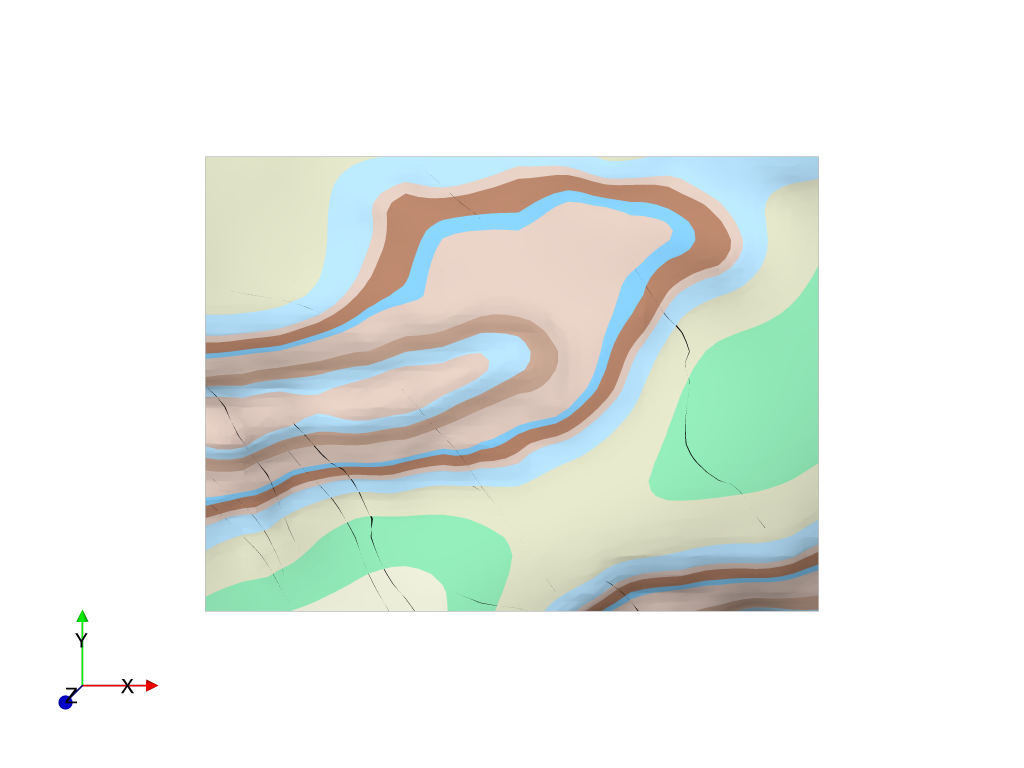

In [15]:
 view.display()